In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

import numpy as np

import matplotlib.pyplot as plt

# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


MNIST

In [2]:
# Load and preprocess the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Add Gaussian noise to the images
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

11490434/11490434 [==============================] - 0s 0us/step


CELEBA

In [ ]:
# !unzip '/content/drive/MyDrive/Stable Diffusion/img_align_celeba.zip' -d '/content/drive/MyDrive/Stable Diffusion/img_align_celeba_dir'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory containing the extracted CelebA dataset
data_dir = '/content/drive/MyDrive/Stable Diffusion/img_align_celeba_dir'

# Create an ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Load the dataset
dataset = datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='input',  # Use 'input' for autoencoder
    color_mode='rgb'  # Use 'rgb' for color images
)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Stable Diffusion/img_align_celeba_dir'

In [ ]:
import numpy as np

MAX_IMAGES = 5000

# Initialize lists to store clean and noisy images
clean_images = []
noisy_images = []

# Load and preprocess 1000 images
num_images = 0
for images, _ in dataset:
    nf = 0.005
    preprocessed_images = images.astype('float32') / 255.0
    noisy_batch = np.clip(preprocessed_images + nf * np.random.normal(loc=0.0, scale=0.1, size=preprocessed_images.shape), 0.0, 1.0)
    clean_images.append(preprocessed_images)
    noisy_images.append(noisy_batch)
    num_images += images.shape[0]
    print(num_images)
    if num_images >= MAX_IMAGES:
        break

# Convert lists to numpy arrays
clean_images = np.concatenate(clean_images, axis=0)
noisy_images = np.concatenate(noisy_images, axis=0)

# Verify the shapes
print("Clean images shape:", clean_images.shape)
print("Noisy images shape:", noisy_images.shape)

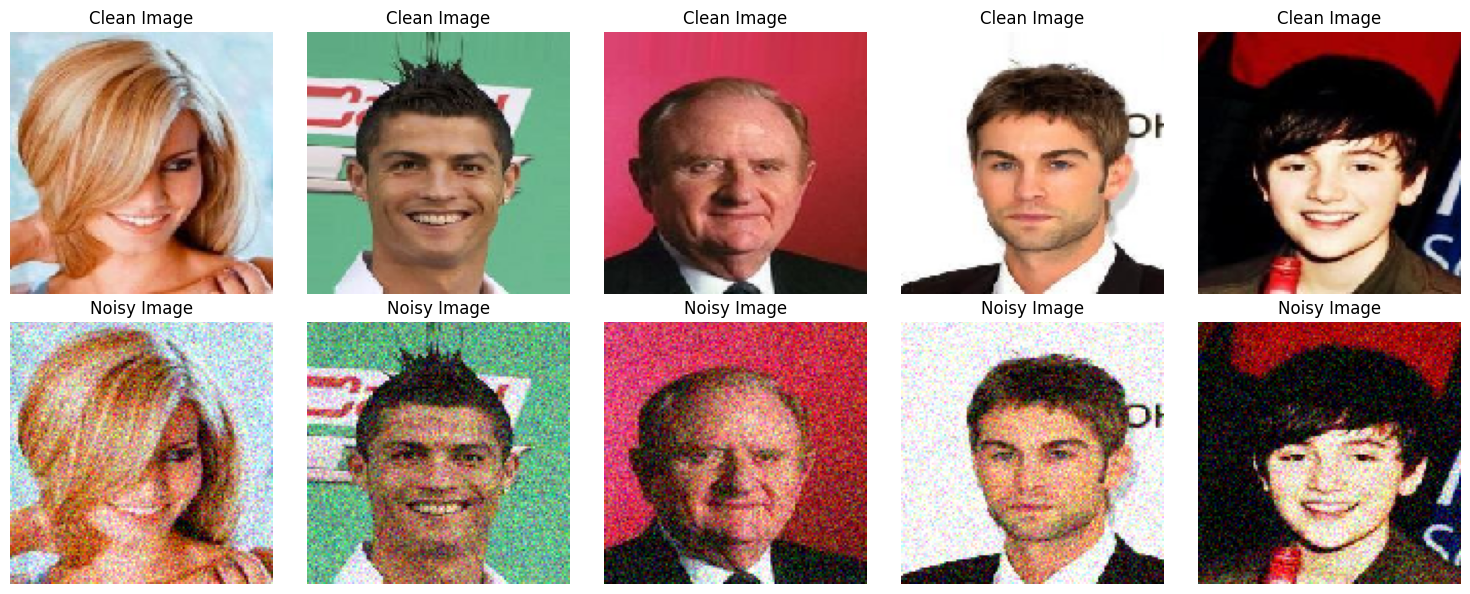

In [ ]:
import matplotlib.pyplot as plt

# Display a few images
num_images_to_display = 5
fig, axs = plt.subplots(2, num_images_to_display, figsize=(15, 6))
for i in range(num_images_to_display):
    axs[0, i].imshow(clean_images[i] * 255)
    axs[0, i].axis('off')
    axs[0, i].set_title('Clean Image')

    axs[1, i].imshow(noisy_images[i] * 255)
    axs[1, i].axis('off')
    axs[1, i].set_title('Noisy Image')

plt.tight_layout()
plt.show()

In [ ]:
# Split the dataset into train and test sets
train_dataset_noisy = noisy_images
train_dataset_clean = clean_images

test_dataset_noisy = noisy_images[-10:]
test_dataset_clean = clean_images[-10:]

In [ ]:
# Split the dataset into train and test sets
train_dataset_noisy = x_train_noisy
train_dataset_clean = x_train

test_dataset_noisy = x_test_noisy[-10:]
test_dataset_clean = x_test[-10:]

In [ ]:
test_dataset_clean.shape

(10, 64, 64, 3)

MODEL

In [ ]:
# Define the input shape
input_shape = (128, 128, 3)

# Define the encoding dimensions
encoding_dim1 = 64
encoding_dim2 = 32

# Define the input layer
input_img = Input(shape=input_shape)

# Define the encoding layers
encoded1 = Conv2D(encoding_dim1, (3, 3), activation='relu', padding='same')(input_img)
encoded2 = MaxPooling2D((2, 2), padding='same')(encoded1)
encoded3 = Conv2D(encoding_dim2, (3, 3), activation='relu', padding='same')(encoded2)
encoded4 = MaxPooling2D((2, 2), padding='same')(encoded3)

# Define the decoding layers
decoded1 = Conv2D(encoding_dim2, (3, 3), activation='relu', padding='same')(encoded4)
decoded2 = UpSampling2D((2, 2))(decoded1)
decoded3 = Conv2D(encoding_dim1, (3, 3), activation='relu', padding='same')(decoded2)
decoded4 = UpSampling2D((2, 2))(decoded3)

# Define the output layer
output_img = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded4)

# Define the autoencoder model
autoencoder = Model(input_img, output_img)

# Define the encoder model
encoder = Model(input_img, encoded4)

# Define the decoder model
decoder_input = Input(shape=(encoding_dim2, 7, 7))
decoder_output = autoencoder.layers[-4](decoder_input)
decoder = Model(decoder_input, decoder_output)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

TRAIN TEST

In [ ]:
# Train the autoencoder
# with tf.device('/gpu:0'):
autoencoder.fit(train_dataset_noisy, train_dataset_clean,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(test_dataset_noisy, test_dataset_clean))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume `autoencoder` is your trained autoencoder model

# Select a few images for prediction
num_images_to_predict = 5
sample_images = noisy_images[:num_images_to_predict]

# Predict on the sample images
predicted_images = autoencoder.predict(sample_images)

# Display the original and predicted images
fig, axs = plt.subplots(2, num_images_to_predict, figsize=(15, 6))
for i in range(num_images_to_predict):
    axs[0, i].imshow(sample_images[i] * 255)
    axs[0, i].axis('off')
    axs[0, i].set_title('Original')

    axs[1, i].imshow(predicted_images[i] * 255)
    axs[1, i].axis('off')
    axs[1, i].set_title('Predicted')

plt.tight_layout()
plt.show()

In [ ]:
# Find the max value in the predicted images
max_value = np.max(clean_images)
print("Max value in predicted images:", max_value * 255)

Max value in predicted images: 1.0000000591389835
